Chase P. Dowling

November 2021

Pacific Northwest National Laboratory

chase.dowling@pnnl.gov

## An Empirical Taxonomy of Common Curb Zoning Configurations in Seattle

This notebook contains relevant data and methods to reproduce results found in Dowling, Maxer, and Ranjbari (2022) "An Empirical Taxonomy of Common Curb Zoning Configurations in Seattle", computing an empirically representative set of curb configurations in Seattle, Washington, USA, using an unsupervised clustering methodology and high spatial resolution curb configuration data.

In [1]:
#Uncomment to have cells fill entire width of the browser
#from IPython.display import display, HTML

#display(HTML(data="""
#<style>
#    div#notebook-container    { width: 95%; }
#    div#menubar-container     { width: 65%; }
#    div#maintoolbar-container { width: 99%; }
#</style>
#"""))

#Tells Jupyter to reload custom classes from scratch everytime an import cell is run, if you edit a custom class
#between imports Jupyter would otherwise need to be restarted completely. Buyer beware: old class objects in the 
#current namespace will cause errors at execution
%load_ext autoreload
%autoreload 2

#conda environment name curb_cluster
#run conda activate curb_cluster

import random
import os
import pickle
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely.geometry
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go
import sys
import utils

#after cloning repo and activating curb_cluster conda environment, call: pip install kmodes from within the repo directory, pip will automatically install the kmodes submodule in the directory (not on pypi) into the active environment
from kmodes.kmodes import KModes #Devos (2015) https://github.com/nicodv/kmodes
from kmodes.util import dissim

#switches matplotlib to show plots in the browser rather than opening a new window
%matplotlib inline

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

import seaborn
seaborn.set()

### Data Preprocessing

Here we load the data on curb zoning in Seattle for 2019. Data is available for download and described [here](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::paid-area-curbspaces/about).
This data is used to populate a map of curb space use in Seattle, for reference purposes, closures, etc, viewable in map form [here](https://seattlecitygis.maps.arcgis.com/apps/MapSeries/index.html?appid=ec2bf6796118412982072feb28d35277). Also load a specially curated GIS dataset of every blockface in Seattle that lists blockface latitude and longitude locations by neighborhood, as well as names of the roads adjacent to the blockface. We use this data, available [here](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::blockface/about) to seperate out only blockfaces in the core downtown for clustering experiments in the more densely populated portions of Seattle, as well as to toss out unwanted curb data on Interstate 5 and 90, and State Route 99. Please note the relevant length data is published in Imperial units of feet.

In [2]:
#zoning data
zoning_data = pd.read_csv("data/Curbspaces_2019.csv")

#GIS data: coordinates, name of adjacent roadway
#with open("data/Blockface.geojson") as d:
#    loc_data = json.load(d)
loc_data = gpd.read_file("data/Blockface.geojson")

In [3]:
space_types = list(zoning_data.SPACETYPEDESC.unique()) #get all space types
space_types.append("MISSING") #turns out there are segments where the label is missing so we add a placeholder

print("Curb zoning types used in Seattle:")
for item in space_types: print("\t" + item)

Curb zoning types used in Seattle:
	CROSSWALK
	PAY STATION
	CLEARANCE
	DRIVEWAY
	NO PARKING
	PAY STATION - TEMP REMOVAL
	TOW AWAY ZONE
	CURB BULB
	CURB RAMP
	HYDRANT
	SHUTTLE BUS ONLY
	LOAD/UNLOAD ZONE
	TIME LIMIT - RES PARKING ZONE
	UNRESTRICTED
	BARRIER AREA
	NOT A DESIGNATED CROSSWALK
	COMMERCIAL VEHICLE LOAD ZONE
	PASSENGER LOAD ZONE
	TIME LIMIT
	PAY STATION - TAXI
	BUS ZONE
	PAY STATION - CVLZ
	PAY STATION - BUS LAYOVER
	ALLEY
	DISABLED ZONE
	PAY STATION - LOAD/UNLOAD ZONE
	CVLZ - PLZ
	PAY STATION - PLZ
	BIKE ZONE
	PAY STATION - MOTORCYCLE
	PAY STATION - VENDOR
	PAY STATION - BUS ZONE
	PAY STATION - SHUTTLE BUS ONLY
	LAW ENFORCEMENT VEHICLES ONLY
	SEATTLE FIRE DEPT ZONE
	TIME LIMIT - PLZ
	PAY STATION - LEVO
	PARKLET
	CHARTER BUS ZONE
	TIME LIMIT - LOAD/UNLOAD ZONE
	CARSHARE/FLEXCAR
	OTHER SPACE TYPE - YES PARKING
	PAY STATION - SCHOOL
	TRUCK LOAD/UNLOAD ZONE
	BUS LAYOVER ZONE
	CVLZ - TRUCK LOAD ONLY
	TAXI ZONE
	PAY STATION - DISABLED
	OTHER SPACE TYPE - NO PARKING
	CVLZ - BUS ZONE

In [4]:
#map all unique space types to an integer for reference
j = 0
integer_mapping = {}
space_type_mapping = {}
for space_type in space_types:
    integer_mapping[space_type] = j
    space_type_mapping[j] = space_type
    j += 1

#ad hoc mapping of space types to a color for later plotting
max_j = np.max(list(integer_mapping.values()))
space_integer_color_map = {}
colors_ordered = list(mcolors.CSS4_COLORS.keys())
random.shuffle(colors_ordered)

for i in range(max_j+1):
    space_integer_color_map[i] = colors_ordered[i]
space_integer_color_map[max_j] = 'black' #manually map the "MISSING" label to black

In [5]:
#Here we condense zone types to categories of related use. This is highly specific to the labels available in Seattle

condensed_space_types_map = {}
for item in ["CLEARANCE", "CURB BULB", "CURB RAMP", "BARRIER AREA", "PARKLET"]:
    condensed_space_types_map[item] = "Curb Bulb/Planter/Physical Barrier"
for item in ["DRIVEWAY", "ALLEY"]:
    condensed_space_types_map[item] = "Driveway"
for item in ["PAY STATION", "PAY STATION - TEMP REMOVAL", "PAY STATION - LOAD/UNLOAD ZONE", "PAY STATION - TAXI", "PAY STATION - CVLZ", "PAY STATION - BUS LAYOVER", "PAY STATION - PLZ", "PAY STATION - MOTORCYCLE", 
          "PAY STATION - VENDOR", "PAY STATION - BUS ZONE", "PAY STATION - SHUTTLE BUS ONLY", "PAY STATION - LEVO", "PAY STATION - SCHOOL", "PAY STATION - CARPOOL", "PAY STATION - TRUCK L/U ZONE", "PAY STATION - RES PARKING ZONE"]:
    condensed_space_types_map[item] = "Paid Parking"
for item in ["NO PARKING", "TOW AWAY ZONE", "OTHER SPACE TYPE - NO PARKING", "NOT A DESIGNATED CROSSWALK"]:
    condensed_space_types_map[item] = "No Parking"
for item in ["PAY STATION - DISABLED", "DISABLED ZONE"]:
    condensed_space_types_map[item] = "Disabled Parking"
for item in ["LOAD/UNLOAD ZONE", "COMMERCIAL VEHICLE LOAD ZONE", "CVLZ - PLZ", "CVLZ - TRUCK LOAD ONLY", "CVLZ - BUS ZONE", "CVLZ - SIGN ONLY", "TRUCK LOAD/UNLOAD ZONE"]:
    condensed_space_types_map[item] = "Commercial Vehicle Loading Zone"
for item in ["PASSENGER LOAD ZONE", "PASSENGER LOAD ZONE - VENDING ZONE", "TAXI ZONE", "CARSHARE/FLEXCAR"]:
    condensed_space_types_map[item] = "Passenger Loading Zone"
for item in ["SHUTTLE BUS ONLY", "BUS ZONE", "CHARTER BUS ZONE", "BUS LAYOVER ZONE"]:
    condensed_space_types_map[item] = "Bus Zone"
for item in ["HYDRANT", "LAW ENFORCEMENT VEHICLES ONLY", "SEATTLE FIRE DEPT ZONE"]:
    condensed_space_types_map[item] = "Emergency Vehicles"
for item in ["TIME LIMIT - RES PARKING ZONE", "TIME LIMIT", "TIME LIMIT - PLZ", "TIME LIMIT - LOAD/UNLOAD ZONE", "TIME LIMIT - BUS LAYOVER", "TIME LIMIT - PEAK PM", "TIME LIMIT - TRUCK L/U ZONE"]:
    condensed_space_types_map[item] = "Free Parking"
for item in ["UNRESTRICTED", "OTHER SPACE TYPE - YES PARKING"]:
    condensed_space_types_map[item] = "Unzoned"
for item in ["BIKE ZONE"]:
    condensed_space_types_map[item] = "Bike Zone"
for item in ["CONSULATE ZONE"]:
    condensed_space_types_map[item] = "Consulate Zone"
for item in ["CARPOOL PARKING - FULL TIME"]:
    condensed_space_types_map[item] = "Carpool Parking"
for item in ["MISSING"]:
    condensed_space_types_map[item] = "Missing"
for item in ["CROSSWALK"]:
    condensed_space_types_map[item] = "Crosswalk"

#map condensed types to integers
j = 0
condensed_integer_mapping = {}
for space_type in space_types:
    if space_type in condensed_space_types_map.keys():
        space_type_condensed = condensed_space_types_map[space_type]
    else:
        space_type_condensed = space_type
    if space_type_condensed not in condensed_integer_mapping.keys():
        condensed_integer_mapping[space_type_condensed] = j
        j += 1
    else:
        pass

print("These are the condensed curb zoning types")
for item in condensed_integer_mapping.keys():
    print("\t" + item)
    
#map each zoning type to a color for later plotting

condensed_color_map = {'Bus Zone': "#FFD700",
             'Missing': "#000000", #black
             'Bike Zone': "#FF7F50",
             'Crosswalk': "#8A2BE2",
             'Curb Bulb/Planter/Physical Barrier': "#FF4500", #brown
             'Driveway': "#A9A9A9", #gray
             'No Parking': "#8B0000", #dark red
             'Emergency Vehicles': "#DC143C", #light red
             'Commercial Vehicle Loading Zone': "#1E90FF", #light blue
             'Free Parking': "#006400", #dark green
             'Paid Parking': "#7FFF00", #chartreuse
             'Unzoned': "#DEB887", #light brown
             'Passenger Loading Zone': "#00FFFF",
             'Disabled Parking': "#FFFAF0", #white
             'Consulate Zone': "#FF00FF", #fuschia
             'Carpool Parking': "#FFE4E1"} #pink
                       
condensed_space_integer_color_map = {}
for label in condensed_color_map.keys():
    condensed_space_integer_color_map[condensed_integer_mapping[label]] = condensed_color_map[label]
                       
#for plotting later, makes the legend easier
condensed_integer_to_space_type = {}
for space_type in condensed_integer_mapping.keys():
    condensed_integer_to_space_type[condensed_integer_mapping[space_type]] = space_type

These are the condensed curb zoning types
	Crosswalk
	Paid Parking
	Curb Bulb/Planter/Physical Barrier
	Driveway
	No Parking
	Emergency Vehicles
	Bus Zone
	Commercial Vehicle Loading Zone
	Free Parking
	Unzoned
	Passenger Loading Zone
	Disabled Parking
	Bike Zone
	Consulate Zone
	Carpool Parking
	Missing


In [6]:
#check all blockface sortings by BLOCK_ST and 
#BLOCK_END if there are multiple dates accounted for in data

#If distance measurements for a zoning are repeated or misaligned we toss that blockface for the purpose of this analysis

#get all elementkeys (unique integer ID's of all blockfaces in Seattle)
ekeys = zoning_data.ELMNTKEY.unique()

bad_keys = set()
for ekey in ekeys:
    block_data = zoning_data.loc[ zoning_data['ELMNTKEY'] == ekey ]
    
    block_st = block_data.BLOCK_ST.values
    block_st_set = list(block_data.BLOCK_ST.unique())
    diff = len(block_st) - len(block_st_set)
    if diff != 0:
        bad_keys.add(ekey)
    
    block_end = block_data.BLOCK_END.values
    block_end_set = list(block_data.BLOCK_END.unique())
    diff = len(block_end) - len(block_end_set)
    if diff != 0:
        bad_keys.add(ekey)
bad_keys = list(bad_keys)

print("Misaligned blockfaces that are being tossed out")
print(bad_keys)
print(np.around((len(bad_keys)/len(ekeys))*100, 2), "% of", len(ekeys), "blockfaces total")

#performing this seperately, tossing out state route and interstate blockface data, highway_keys and bad_keys may overlap
highway_keys = set()
highways = ["I90", "I5", "SR99"]

for ekey in ekeys:
    geo_block_data = loc_data.loc[ loc_data['ELMNTKEY'] == ekey ]
    try: #some descriptions are empty
        desc = geo_block_data["UNITDESC"].iloc[0]
        if any([ highway in desc for highway in highways ]):
            highway_keys.add(ekey)
    except:
        pass
        
print("Highway blockfaces being tossed out")
print(np.around((len(highway_keys)/len(ekeys))*100, 2), "% of", len(ekeys), "blockfaces total")

Misaligned blockfaces that are being tossed out
[31490, 9465, 77318, 57861, 78853, 36105, 54541, 32910, 36493, 57901, 37433, 32469, 1589, 56085, 57269, 77369, 56318, 36126]
0.67 % of 2697 blockfaces total
Highway blockfaces being tossed out
0.22 % of 2697 blockfaces total


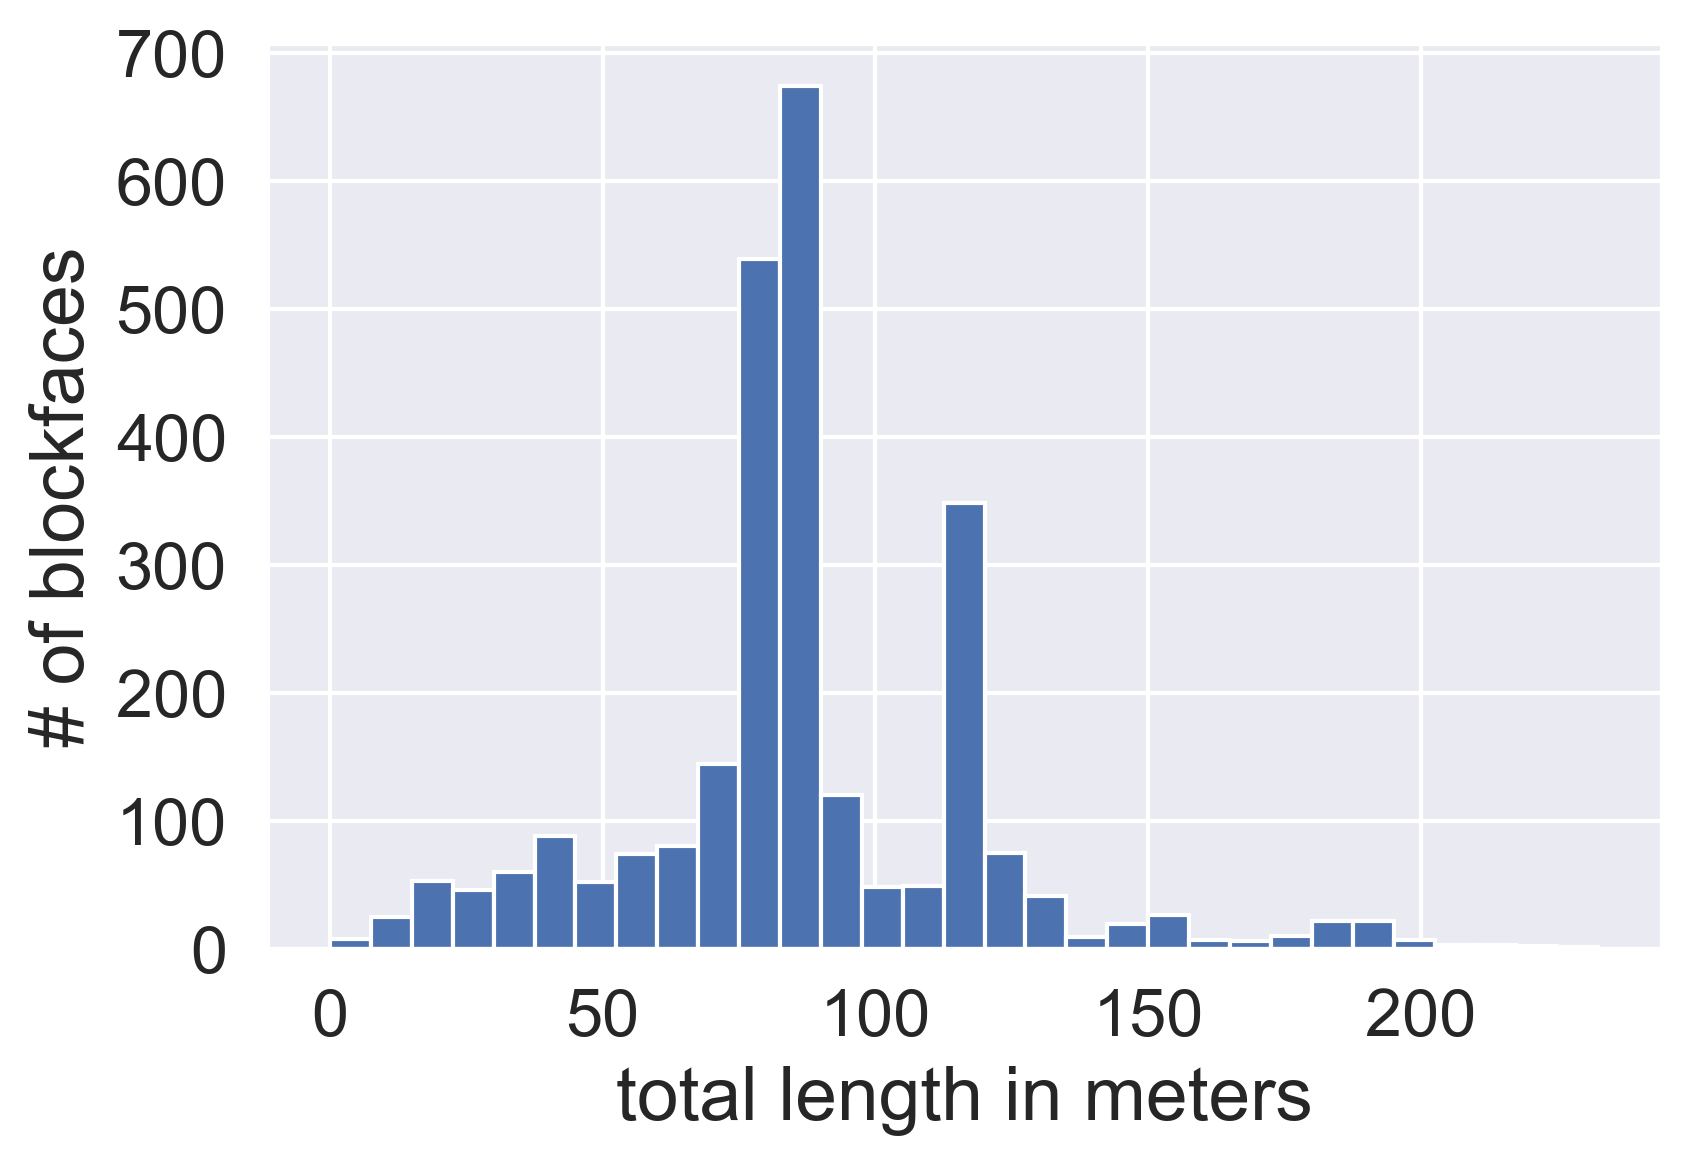

In [7]:
#Blockface lengths and constituent zones are measured to within a tenth of a foot
#Here we bin blockfaces by length, increments of 25 feet, for the purpose of clustering blockfaces of similar length
lengths = []
length_bins = [ [] for i in range(int(2000/25)) ]

for ekey in ekeys:
    if ekey in bad_keys or ekey in highway_keys:
        pass
    else:
        block_data = zoning_data.loc[zoning_data['ELMNTKEY'] == ekey]
        block_length = block_data.SHAPE_Length.sum()
        lengths.append(block_length)
        length_bin_i = int(block_length/25)
        length_bins[length_bin_i].append(ekey)
        
plt.hist(0.30*np.asarray(lengths), bins=0.30*np.arange(0,800,25))
plt.xlabel("total length in meters", fontsize=18)
plt.ylabel("# of blockfaces", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#For reference, the largest bins are:
#676 blockfaces in [275,300) ekeys in index 11 of length_bins
#539 blockfaces in [250,275) index 10
#348 blockfaces in [375,400) index 15

In [8]:
#here we compute all the length normalized blockface label sequences for every blockface elementkey, and each subsequent experiment draws on this list for various subsets of elementkeys (e.g. downtown core only, similar block lengths only)

block_allocs_norm_length = {} #will map blockface ekey to length normalized zoning of blockface
block_allocs_norm_length_condensed = {} #will map blockface ekey to length normalized condensed zoning of blockface

label_increment = 0.4 #for generating blockface label vectors that depend on the length of the blockface #0.49 is minimum positive difference between labels
normed_vector_length = 100 #for generating blockface label vectors of all equal total length
max_block_len = 0

#for element key, get all rows
for ekey in ekeys:
    if ekey in bad_keys or ekey in highway_keys:
        pass
    else:
        block_data = zoning_data.loc[zoning_data['ELMNTKEY'] == ekey]

        #need to sort sequence of BLOCK_ST to BLOCK_END
        block_data = block_data.sort_values('BLOCK_ST')
        block_st = np.min(block_data.BLOCK_ST.values) #numercial start of all zonings on block
        block_end = np.max(block_data.BLOCK_END.values) #numercial end of all zonings on block
        total_len = block_end - block_st

        #populate vector of normalized length with labels
        length_normal_label_vector = [ "" for i in range(normed_vector_length) ] #label vector thats normalized to the same length for all blockfaces
        condensed_length_normal_label_vector = [ "" for i in range(normed_vector_length) ]

        #iterate through zonings for current blockface
        for index, row in block_data.iterrows():
            curr_zone = integer_mapping[row['SPACETYPEDESC']] #get integer label
            try:
                condensed_curr_zone = condensed_integer_mapping[condensed_space_types_map[row['SPACETYPEDESC']]] #get condensed integer label
            except:
                condensed_curr_zone = condensed_integer_mapping[row['SPACETYPEDESC']]
            b_seg_st = row['BLOCK_ST'] #get the numercial start of current zoning
            b_seg_end = row['BLOCK_END'] #get the numerical end of current zoning

            #normalize and get normed_length_vector_length dependent indecies
            norm_seg_st = (b_seg_st - block_st)/(total_len) #get 0-1 position of current zoning start on current block
            norm_seg_end = (b_seg_end - block_st)/(total_len) #get 0-1 position of current zoning end on current block
            st_ind = int(norm_seg_st*normed_vector_length) #recall int() is natively a floor function, so no overlaps
            end_ind = int(norm_seg_end*normed_vector_length)
            for i in range(st_ind, end_ind+1):
                if i == normed_vector_length:
                    pass
                else:
                    length_normal_label_vector[i] = curr_zone
                    condensed_length_normal_label_vector[i] = condensed_curr_zone

        #update block zonings            
        for j, item in enumerate(length_normal_label_vector):
            if item == "":
                length_normal_label_vector[j] = integer_mapping["MISSING"]
                condensed_length_normal_label_vector[j] = condensed_integer_mapping["Missing"]
        block_allocs_norm_length[ekey] = length_normal_label_vector
        block_allocs_norm_length_condensed[ekey] = condensed_length_normal_label_vector

In [9]:
#print an example input sample

example_block = block_allocs_norm_length[ekeys[0]]
labeled_vector = [ space_types[i] for i in example_block ]
print(labeled_vector)
print("\n")

#recall, this vector represents an order-preserving sequence of curb zones. Each element is 0.1% of the total curb length. The first 15 labels are "CLEARANCE", meaning that 1.5% of the total blockface length at one
#end of the curb is dedicated to "CLEARANCE" zoning. This is approximately 4 feet

block_data = zoning_data.loc[zoning_data['ELMNTKEY'] == ekeys[0]]
block_length = block_data.SHAPE_Length.sum()
print("True length of \"clearance\" zoning at beginning of this example input:")
print(0.015*block_length, " feet")

['CLEARANCE', 'CROSSWALK', 'CROSSWALK', 'CROSSWALK', 'CROSSWALK', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING',

## Analysis

### Clustering all blockfaces regardless of location and true length, full label set

In [10]:
# setting this ensures reported results can be reproduced exactly, comment out this line for new analyses
np.random.seed(123123)

In [ ]:
#Using basic matching dissimliarty in kmodes.dissim takes some time to compute on a laptop
#The full clustering routine is included here for convenience but is called from utils.py for subsequent experiments

#here we can introduce other dissimilarity measures in the kmodes library
#e.g. dissim_func = dissim.ng_dissim or dissim.jaccard_dissim_label
# this work uses simple matching dissimilarity
dissim_func = dissim.matching_dissim

#cluster normalized length vectors
#stack samples into train and validation data sets
all_data = []
for ekey in block_allocs_norm_length.keys():
    all_data.append(block_allocs_norm_length[ekey])
all_data = np.asarray(all_data)
print(all_data.shape[0], " total samples")

val_inds = np.random.choice(all_data.shape[0], size=int(0.1*all_data.shape[0]), replace=False) #hold out 10% of the data for cross validation
train_inds = np.asarray([i for i in range(all_data.shape[0]) if i not in val_inds]) #use the rest for training

train_data = all_data[train_inds,:]
val_data = all_data[val_inds,:]

models = []
counter = 0
k_max = 35 #here we look at clustering results for k = 2 through k_max to decide on an optimal number k via held-out cross validation

for i in range(2,k_max):
    print("Training model for ", str(i), "clusters")
    
    #initialize and train the model
    km = KModes(n_clusters=i, init='Cao', n_init=5, verbose=0, max_iter=100, cat_dissim=dissim_func)
    clusters = km.fit_predict(train_data)
    models.append([km])
    
    #get the predicted clusters of the held out training and validation data
    val_assignments = np.asarray(km.predict(val_data))
    train_assignments = np.asarray(km.predict(train_data))
    
    val_var_dists = []
    train_var_dists = []
    for j in range(i):
        #inds = np.where(np.any(assignments==0, axis=0))
        val_inds = np.argwhere(val_assignments==j)[:,0]
        train_inds = np.argwhere(train_assignments==j)[:,0]

        #compute within cluster variance with dissim.matching_dissim for training and validation data, when validation data distance variance diverges as a function k, we know k is too large and the model has overfit
        centroid = km.cluster_centroids_[j]
        train_dist = dissim.matching_dissim(train_data[train_inds,:], centroid) #compute the distances of all the training samples
        train_var_dist = np.var(train_dist) #compute the variance of these distances
        train_var_dists.append(train_var_dist) #save with model
        
        val_dist = dissim.matching_dissim(val_data[val_inds,:], centroid) #compute the distances of all the validation samples
        val_var_dist = np.var(val_dist) #compute the variance of these distances
        val_var_dists.append(val_var_dist) #save with model
        
    models[counter].append(np.mean(train_var_dists))
    models[counter].append(np.mean(val_var_dists))
    
    counter+=1 #increment counter for saving models and validation score
    km = None #reset model variable

In [ ]:
#save models, load models, for later analysis
#Here we're saving results from k's 2 to 34, for zoning increments of 1%

for i in range(k_max-2):
    if not os.path.exists("models/n_" + str(normed_vector_length) + "_all_blockfaces"):
        os.mkdir("models/n_" + str(normed_vector_length) + "_all_blockfaces")
    with open("models/n_" + str(normed_vector_length) + "_all_blockfaces/k_" + str(i+2) + "_n_" + str(normed_vector_length) + ".pck", 'wb') as d:
        pickle.dump(models[i], d)

In [ ]:
#plot validation within-cluster variance
train_variances = [i[1] for i in models ]
val_variances = [ i[2] for i in models ]

plt.plot(np.arange(2,k_max,1), train_variances, label="training data")
plt.plot(np.arange(2,k_max,1), val_variances, label="validation data")
plt.xlabel("Number of clusters")
plt.ylabel("Within cluster variance")
plt.legend()
plt.show()

In [ ]:
#To do: Assume block-faces are Poisson distributed across clusters, compute exponential fit (smaller parameter = fatter tail). This will tell us if we're identifying latent clusters as k increases

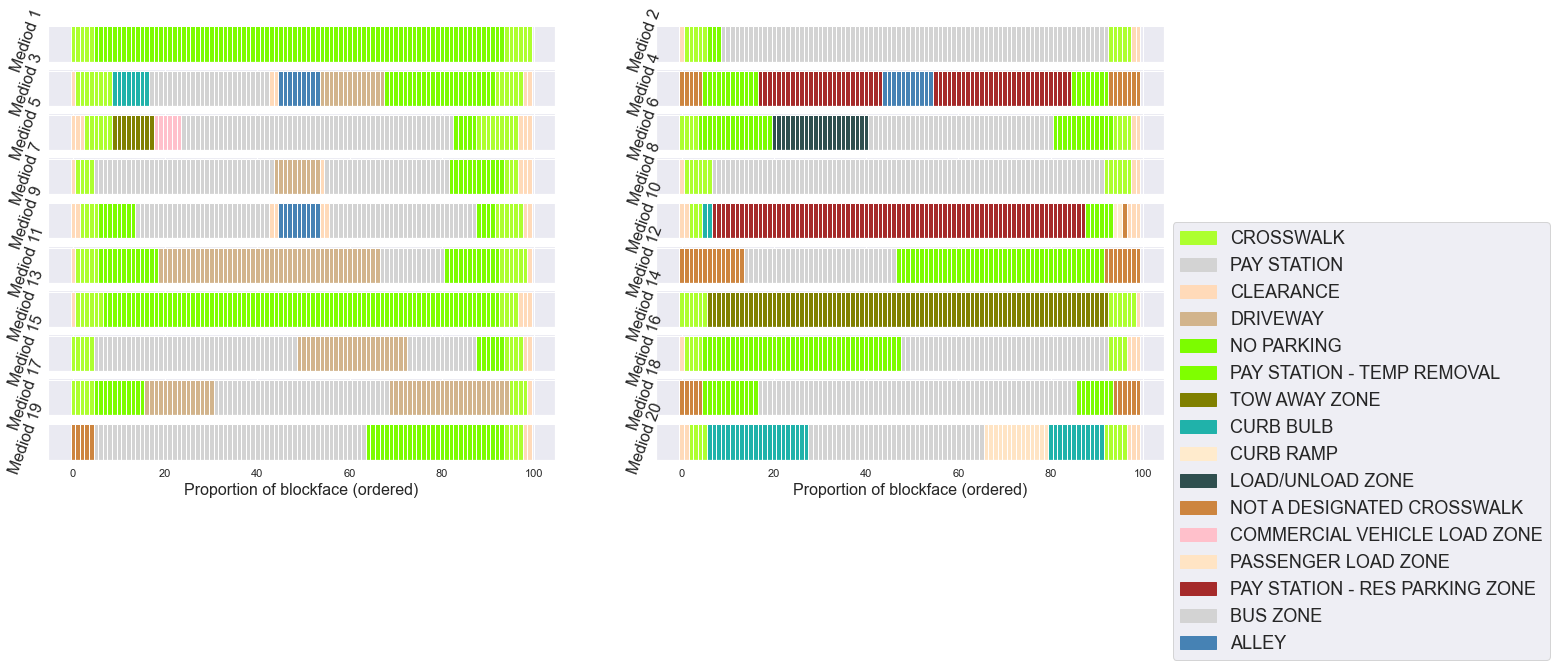

In [103]:
#Roughly visualize all curb configurations (randomly chosen colors per plot---not optimal for visualization)

#need this to be subplot function, create legend for each subplot
#https://stackoverflow.com/questions/27016904/matplotlib-legends-in-subplot

#load a model, plot the centroids
k_star = 20
path = "models/n_" + str(normed_vector_length) + "_all_blockfaces/k_" + str(k_star) + "_n_" + str(normed_vector_length) + ".pck"
        
#plot the centroids
utils.plot_configs(path, space_integer_color_map, space_type_mapping)


### Clustering all blockfaces regardless of location and true length, condensed label set

In [ ]:
#Using basic matching dissimliarty in kmodes.dissim takes some time to compute on a laptop

#cluster normalized length vectors
#stack samples into train and validation data sets
k_max = 27
ekey_to_block_alloc = block_allocs_norm_length_condensed

models = utils.kmodes_clustering_loop_k(k_max, block_allocs_norm_length_condensed, dissim_func)

In [ ]:
#save models, load models, for later analysis
#Here we're saving results from k's 2 to 34, for zoning increments of 1%

for i in range(k_max-2):
    if not os.path.exists("models/n_" + str(normed_vector_length) + "_all_blockfaces_condensed_labels"):
        os.mkdir("models/n_" + str(normed_vector_length) + "_all_blockfaces_condensed_labels")
    with open("models/n_" + str(normed_vector_length) + "_all_blockfaces_condensed_labels/k_" + str(i+2) + "_n_" + str(normed_vector_length) + ".pck", 'wb') as d:
        pickle.dump(models[i], d)

In [ ]:
#plot validation within-cluster variance
train_variances = [i[1] for i in models ]
val_variances = [ i[2] for i in models ]

plt.plot(np.arange(2,k_max,1), train_variances, label="training data")
plt.plot(np.arange(2,k_max,1), val_variances, label="validation data")
plt.xlabel("Number of clusters")
plt.ylabel("Within cluster variance")
plt.legend()
plt.show()

In [ ]:
#need this to be subplot function, create legend for each subplot
#https://stackoverflow.com/questions/27016904/matplotlib-legends-in-subplot

#load a model, plot the centroids
k_star = 12
path = "models/n_" + str(normed_vector_length) + "_all_blockfaces_condensed_labels/k_" + str(k_star) + "_n_" + str(normed_vector_length) + ".pck"
        
#plot the centroids
utils.plot_configs(path, condensed_space_integer_color_map, condensed_integer_to_space_type)

#### Clustering blockfaces of similar true length

In [ ]:
ekeys_trunc = length_bins[11] #these blockfaces are all in the [275,300) foot length interval, the largest set of similarly lengthed blockfaces in the city
print(len(ekeys_trunc))
k_max = 27

models = utils.kmodes_clustering_loop_k(k_max, block_allocs_norm_length, ekeys=ekeys_trunc)

In [ ]:
#save models, load models, for later analysis
#Here we're saving results from k's 2 to 34, for zoning increments of 1%

for i in range(k_max-2):
    if not os.path.exists("models/n_" + str(normed_vector_length) + "_275ft_blockfaces"):
        os.mkdir("models/n_" + str(normed_vector_length) + "_275ft_blockfaces")
    with open("models/n_" + str(normed_vector_length) + "_275ft_blockfaces/k_" + str(i+2) + "_n_" + str(normed_vector_length) + ".pck", 'wb') as d:
        pickle.dump(models[i], d)

In [ ]:
#plot validation within-cluster variance
train_variances = [i[1] for i in models ]
val_variances = [ i[2] for i in models ]

plt.plot(np.arange(2,k_max,1), train_variances, label="training data")
plt.plot(np.arange(2,k_max,1), val_variances, label="validation data")
plt.xlabel("Number of clusters")
plt.ylabel("Within cluster variance")
plt.legend()
plt.show()

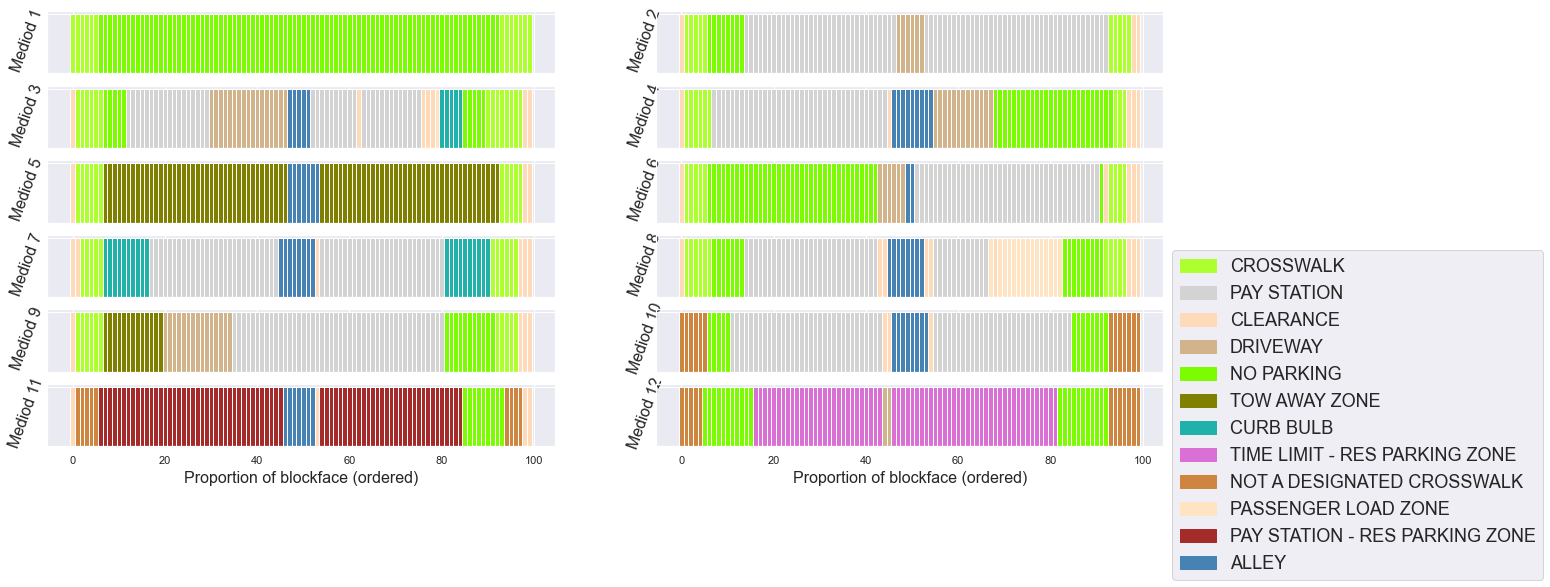

In [102]:
#load a model, plot the centroids
k_star = 12
path = "models/n_" + str(normed_vector_length) + "_275ft_blockfaces/k_" + str(k_star) + "_n_" + str(normed_vector_length) + ".pck"
        
#plot the centroids
utils.plot_configs(path, space_integer_color_map, space_type_mapping)

#### Clustering blockfaces in the core downtown

Here we load a specially curated GIS dataset of every blockface in Seattle that lists blockface latitude and longitude locations by neighborhood. We use this data, available [here](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::blockface/about) to seperate out only blockfaces in the Belltown, Financial District, International District (named Chinatown/ID), Commerical Core, Pioneer Square, Pike-Pine, South Lake Union, and Denny Triangle neighborhoods

In [104]:
#find all blocks within 0.8 km (1/2 mile) of 47.609722, -122.333056
#can adjust to any blockface within some distance of blockfaces in PAIDAREA neighborhoods
downtown_blocks = set()
threshold = 0.015
center = (47.61484, -122.3353)

for index, row in loc_data.iterrows():
    feature = row['geometry']
    if isinstance(feature, shapely.geometry.linestring.LineString):
        linestrings = [feature]
    elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
        linestrings = feature.geoms
    else:
        continue
    for linestring in linestrings:
        lons, lats = linestring.xy
        for pair in zip(lons, lats):
            delta = np.sqrt(np.power(pair[1]-center[0], 2) + np.power(pair[0] - center[1], 2))
            if delta < threshold and "I5" not in row["UNITDESC"] and "I90" not in row["UNITDESC"] and "SR99" not in row["UNITDESC"]:
                downtown_blocks.add(row['ELMNTKEY'])

downtown_blocks = list(downtown_blocks)
#not all blockfaces in geojson data appear in the zoning data, take set intersection
all_blocks = set(block_allocs_norm_length_condensed.keys())

downtown_ekeys = [ ekey for ekey in downtown_blocks if ekey in all_blocks ]
print(len(downtown_ekeys))

1695


In [11]:
#cluster downtown blocks
k_max = 15

models = utils.kmodes_clustering_loop_k(k_max, block_allocs_norm_length_condensed, dissim_func, ekeys=downtown_ekeys)

1695  total samples
Training model for  2 clusters
Training model for  3 clusters
Training model for  4 clusters
Training model for  5 clusters
Training model for  6 clusters
Training model for  7 clusters
Training model for  8 clusters
Training model for  9 clusters
Training model for  10 clusters
Training model for  11 clusters
Training model for  12 clusters
Training model for  13 clusters
Training model for  14 clusters


In [12]:
#save models, load models, for later analysis
#Here we're saving results from k's 2 to 34, for zoning increments of 1%

for i in range(k_max-2):
    if not os.path.exists("models/n_" + str(normed_vector_length) + "_downtown_blockfaces_condensed_labels"):
        os.mkdir("models/n_" + str(normed_vector_length) + "_downtown_blockfaces_condensed_labels")
    with open("models/n_" + str(normed_vector_length) + "_downtown_blockfaces_condensed_labels/k_" + str(i+2) + "_n_" + str(normed_vector_length) + ".pck", 'wb') as d:
        pickle.dump(models[i], d)

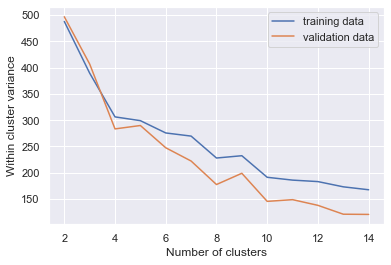

In [13]:
#plot validation within-cluster variance
train_variances = [i[1] for i in models ]
val_variances = [ i[2] for i in models ]

plt.plot(np.arange(2,k_max,1), train_variances, label="training data")
plt.plot(np.arange(2,k_max,1), val_variances, label="validation data")
plt.xlabel("Number of clusters")
plt.ylabel("Within cluster variance")
plt.legend()
plt.show()

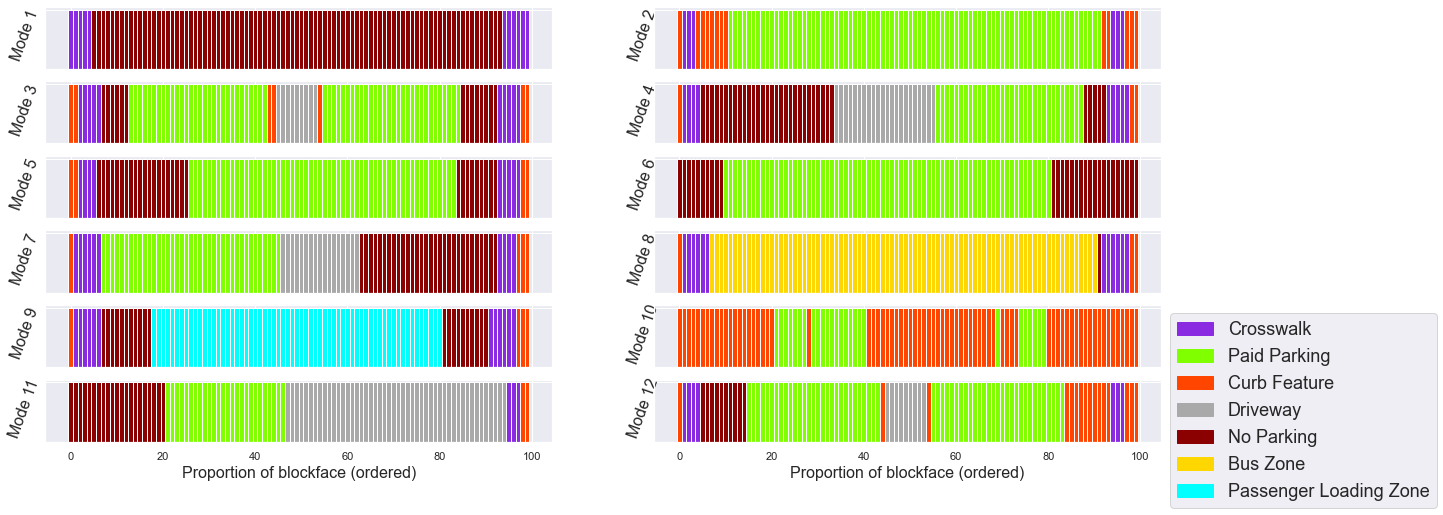

In [29]:
#load a model, plot the centroids
k_star = 12
path = "models/n_" + str(normed_vector_length) + "_downtown_blockfaces_condensed_labels/k_" + str(k_star) + "_n_" + str(normed_vector_length) + ".pck"
        
#plot the centroids
utils.plot_configs(path, condensed_space_integer_color_map, condensed_integer_to_space_type)

### Cluster blockfaces downtown of similar true length

In [29]:
ekeys_trunc = length_bins[11] #these blockfaces are all in the [275,300) foot length interval, the largest set of similarly lengthed blockfaces in the city
k_max = 27

#find all blocks within 0.8 km (1/2 mile) of 47.609722, -122.333056
#can adjust to any blockface within some distance of blockfaces in PAIDAREA neighborhoods
downtown_blocks = set()
threshold = 0.015
center = (47.61484, -122.3353)

for index, row in loc_data.iterrows():
    feature = row['geometry']
    if isinstance(feature, shapely.geometry.linestring.LineString):
        linestrings = [feature]
    elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
        linestrings = feature.geoms
    else:
        continue
    for linestring in linestrings:
        lons, lats = linestring.xy
        for pair in zip(lons, lats):
            delta = np.sqrt(np.power(pair[1]-center[0], 2) + np.power(pair[0] - center[1], 2))
            if delta < threshold and "I5" not in row["UNITDESC"] and "I90" not in row["UNITDESC"] and "SR99" not in row["UNITDESC"]:
                if row['ELMNTKEY'] in ekeys_trunc:
                    downtown_blocks.add(row['ELMNTKEY'])

downtown_blocks_same_length = list(downtown_blocks)
#not all blockfaces in geojson data appear in the zoning data, take set intersection
all_blocks = set(block_allocs_norm_length_condensed.keys())

downtown_ekeys_same_length = [ ekey for ekey in downtown_blocks if ekey in all_blocks ]

In [12]:
models = utils.kmodes_clustering_loop_k(k_max, block_allocs_norm_length, ekeys=downtown_ekeys_same_length)

449  total samples
Training model for  2 clusters
Training model for  3 clusters
Training model for  4 clusters
Training model for  5 clusters
Training model for  6 clusters
Training model for  7 clusters
Training model for  8 clusters
Training model for  9 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  10 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  11 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  12 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  13 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  14 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  15 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  16 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  17 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  18 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  19 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  20 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  21 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  22 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  23 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  24 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  25 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model for  26 clusters


C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dowl271\AppData\Local\Continuum\anaconda3\envs\curb_cluster\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
#save models, load models, for later analysis
#Here we're saving results from k's 2 to 34, for zoning increments of 1%

for i in range(k_max-2):
    if not os.path.exists("models/n_" + str(normed_vector_length) + "_downtown_275ft_blockfaces"):
        os.mkdir("models/n_" + str(normed_vector_length) + "_downtown_275ft_blockfaces")
    with open("models/n_" + str(normed_vector_length) + "_downtown_275ft_blockfaces/k_" + str(i+2) + "_n_" + str(normed_vector_length) + ".pck", 'wb') as d:
        pickle.dump(models[i], d)

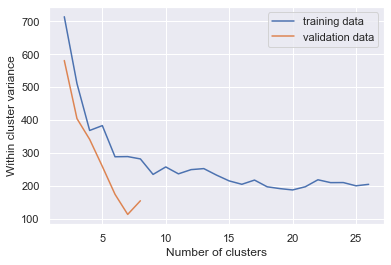

In [14]:
#plot validation within-cluster variance
train_variances = [i[1] for i in models ]
val_variances = [ i[2] for i in models ]

plt.plot(np.arange(2,k_max,1), train_variances, label="training data")
plt.plot(np.arange(2,k_max,1), val_variances, label="validation data")
plt.xlabel("Number of clusters")
plt.ylabel("Within cluster variance")
plt.legend()
plt.show()

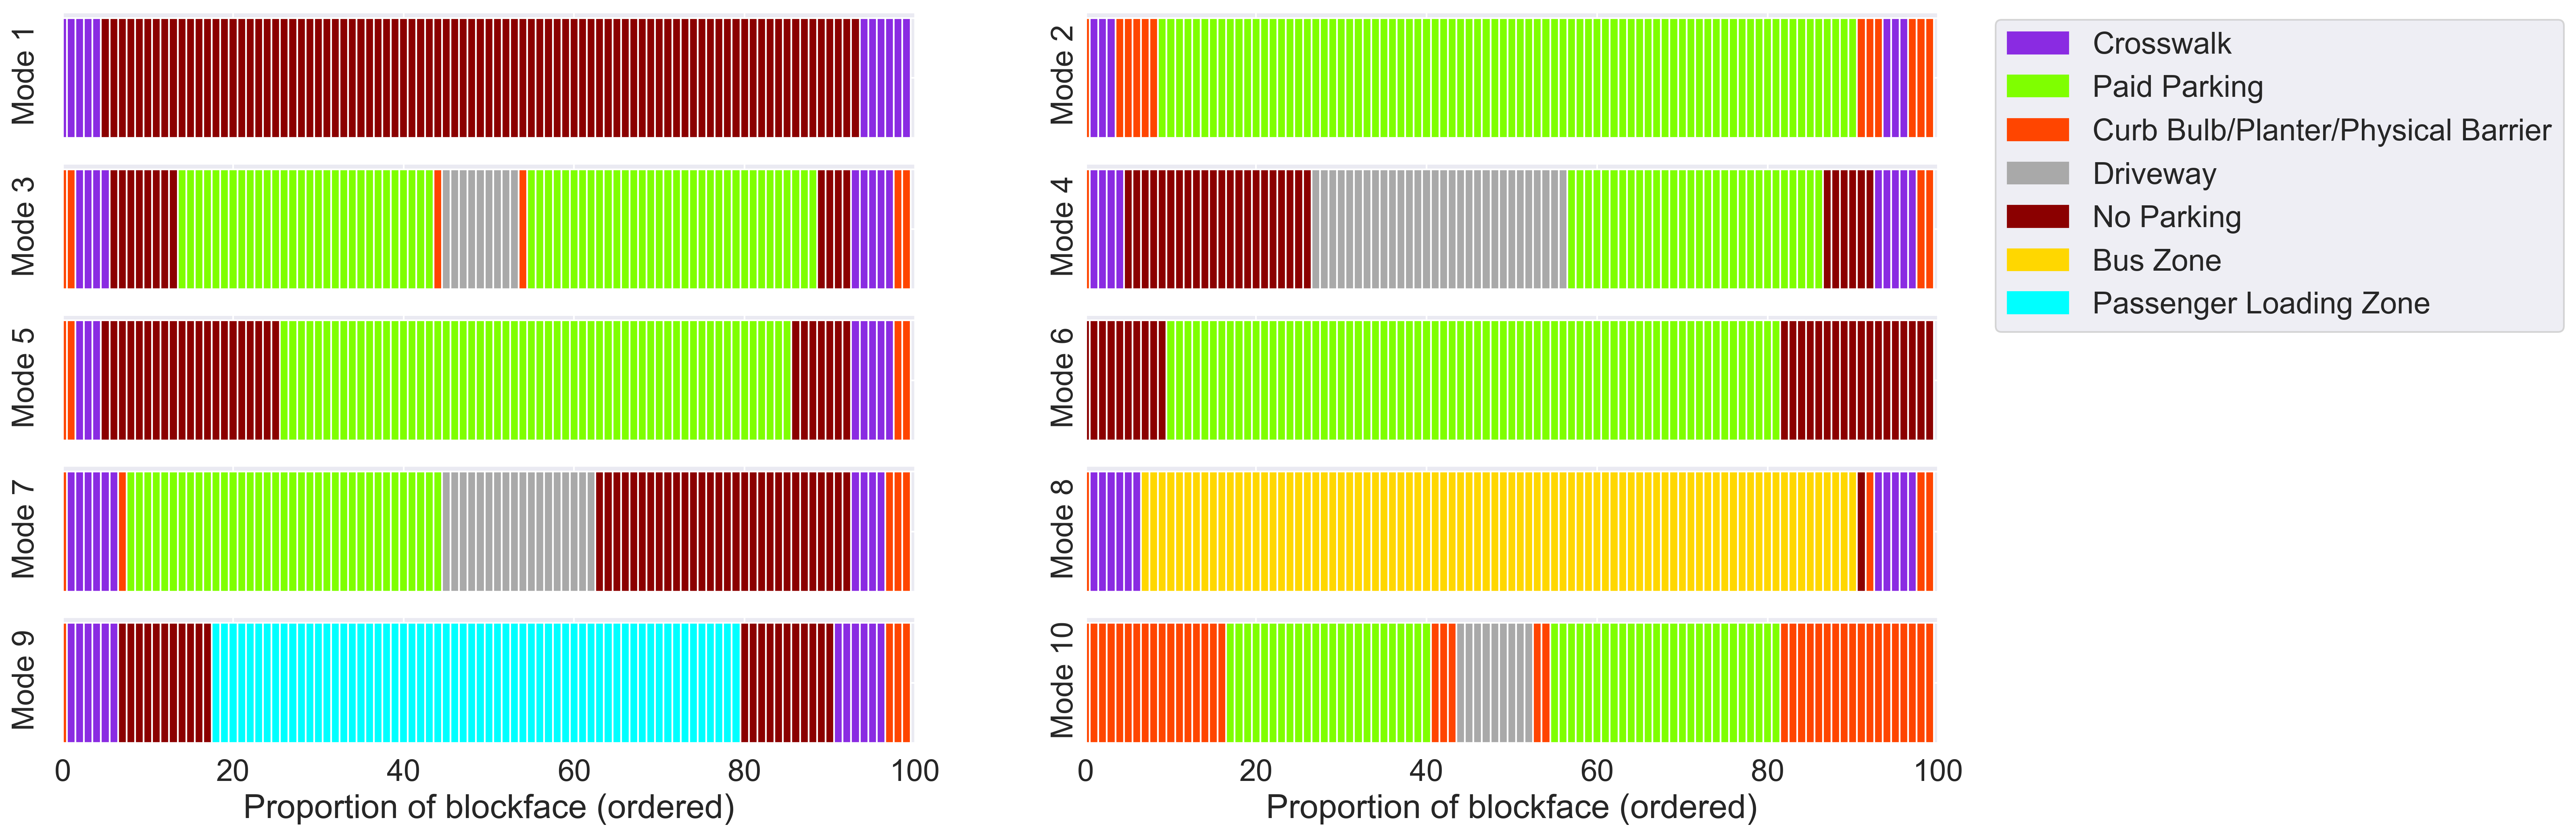

In [12]:
#load a model, plot the centroids
k_star = 10
path = "models/n_" + str(normed_vector_length) + "_downtown_blockfaces_condensed_labels/k_" + str(k_star) + "_n_" + str(normed_vector_length) + ".pck"
        
#plot the centroids
utils.plot_configs(path, condensed_space_integer_color_map, condensed_integer_to_space_type)

### Visualize cluster locations

In [34]:
#load model for predictions---this is f
with open(path, 'rb') as d:
    km = pickle.load(d)[0]

#get all the downtown blockface cluster predictions
downtown_data = []
ordered_ekeys = []
for ekey in downtown_ekeys_same_length:
    ordered_ekeys.append(ekey)
    downtown_data.append(block_allocs_norm_length_condensed[ekey])
downtown_data = np.asarray(downtown_data)
clusters = km.predict(downtown_data)

#generate a unique color for each of the k clusters
cluster_color_map = {}
colors_ordered = list(mcolors.CSS4_COLORS.keys())
random.shuffle(colors_ordered)

for i in range(k_star+3): #something going on with save
    cluster_color_map[i] = colors_ordered[i]

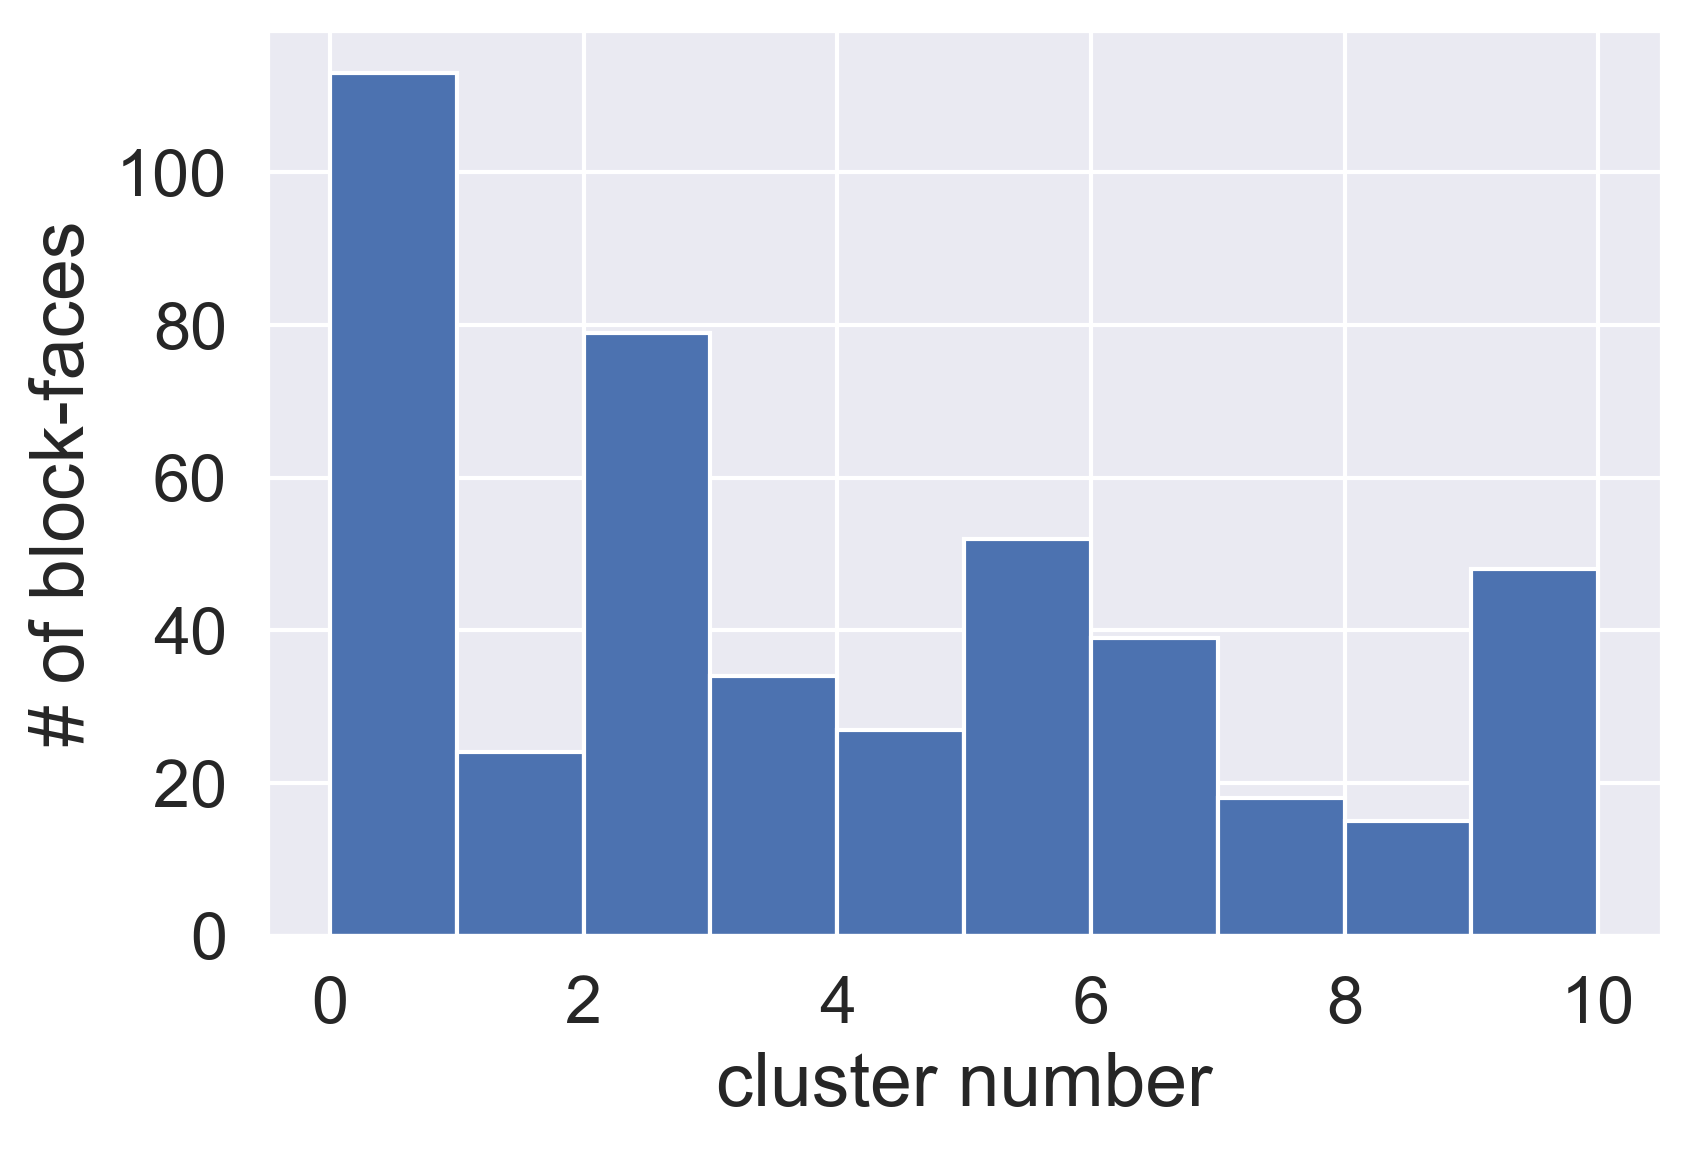

In [31]:
#distribution of block-faces per cluster

plt.hist(clusters, bins=np.arange(0,11,1))
#plt.title("Cluster membership", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("# of block-faces", fontsize=18)
plt.xlabel("cluster number", fontsize=18)
plt.show()



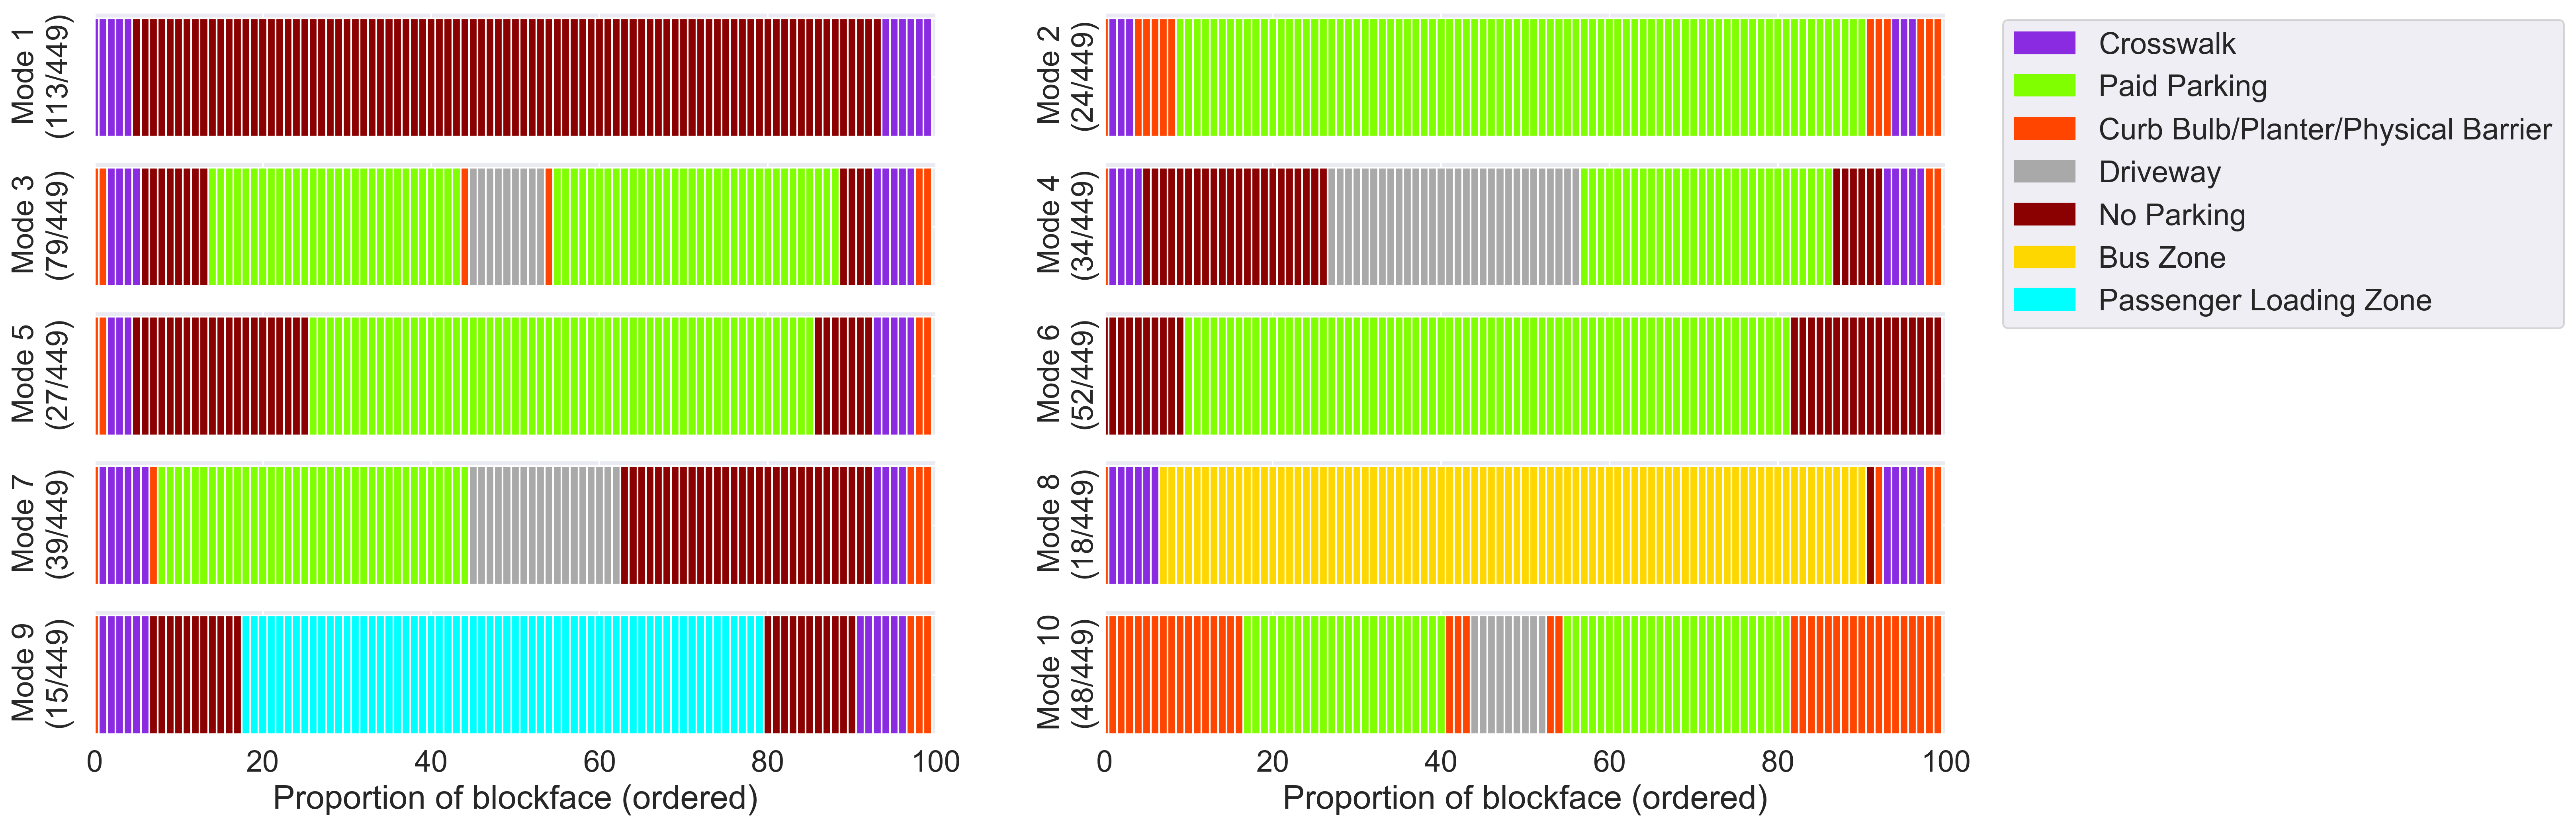

In [32]:
#plot the centroids w/ membership percentages
cluster_totals = [0 for i in range(k_star)]
for i in clusters:
    cluster_totals[i] = cluster_totals[i] + 1
utils.plot_configs_with_membership(path, condensed_space_integer_color_map, condensed_integer_to_space_type, len(clusters), cluster_totals)

In [43]:
#plot all blockfaces in the study area regardless of cluster
#plot bus stop and PLZ cluster labels on map
downtown_df = loc_data.loc[loc_data['ELMNTKEY'].isin(downtown_blocks_same_length)]

#grab a single blockfaces worth of data
ekey = ordered_ekeys[0]
cluster = clusters[0]
color = cluster_color_map[cluster]
downtown_df_select = downtown_df.loc[downtown_df['ELMNTKEY'] == ekey]
feature = downtown_df_select.geometry
if isinstance(feature, shapely.geometry.linestring.LineString):
    linestrings = [feature]
elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
    linestrings = feature.geoms
else:
    linestrings = feature
lats = []
lons = []

for linestring in linestrings:
    lons, lats = linestring.xy
    lats += lats
    lons += lons
names = [ekey]*len(lats)

#initialize figure with single blockface
init_fig = go.Figure(go.Scattermapbox(mode="lines",lat=[ l for l in lats], lon=[l for l in lons], 
                                      marker = {'color': "green", 'size': 10}))

#add center of study area
lat_center = 47.61484
lon_center = -122.3353
init_fig.add_trace(go.Scattermapbox(
                    lat=[lat_center],
                    lon=[lon_center],
                    mode='markers',
                    marker_size=9, marker_color='blue'))

#add boundary circle of study area
R = 0.015 + 0.001
t = np.linspace(0, 2*np.pi, 100)
circle_lon = lon_center + R*np.cos(t)
circle_lat = lat_center + R*np.sin(t)

coords=[]
for lo, la in zip(list(circle_lon), list(circle_lat)):
    coords.append([lo, la]) 
    
init_fig.add_trace(go.Scattermapbox(mode="lines", lat = [l[1] for l in coords], lon =[ l[0] for l in coords],
                                    marker = {'color': 'blue'}, marker_size=9))

init_fig.update_layout(showlegend=False)

for j in range(len(ordered_ekeys)):
    ekey = ordered_ekeys[j]
    cluster = clusters[j]
    downtown_df_select = downtown_df.loc[downtown_df['ELMNTKEY'] == ekey]
    feature = downtown_df_select.geometry
    if isinstance(feature, shapely.geometry.linestring.LineString):
        linestrings = [feature]
    elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
        linestrings = feature.geoms
    else:
        linestrings = feature
    lats = []
    lons = []
    for linestring in linestrings:
        lons, lats = linestring.xy
        lats += lats
        lons += lons
    names = [ekey]*len(lats)
    init_fig.add_trace(go.Scattermapbox(mode="lines", lat=[ l for l in lats], lon=[l for l in lons], 
                                        marker = {'color': "green", 'size': 10}))

init_fig.update_geos(fitbounds="locations")
init_fig.update_layout(mapbox_style="carto-positron", width=800, height=800)
init_fig.show()

In [42]:
#plot bus stop and PLZ cluster labels on map
downtown_df = loc_data.loc[loc_data['ELMNTKEY'].isin(downtown_blocks_same_length)]

#pick a cluster number (doesn't neccessarily need to be the bus zone cluster)
cluster_num = 2
first_bus_idx = np.where(clusters == cluster_num)[0][0] #all the lusters labeled for busses

#grab a single blockfaces worth of data
ekey = ordered_ekeys[first_bus_idx]
cluster = clusters[first_bus_idx]
color = cluster_color_map[cluster]
downtown_df_select = downtown_df.loc[downtown_df['ELMNTKEY'] == ekey]
feature = downtown_df_select.geometry
if isinstance(feature, shapely.geometry.linestring.LineString):
    linestrings = [feature]
elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
    linestrings = feature.geoms
else:
    linestrings = feature
lats = []
lons = []

for linestring in linestrings:
    lons, lats = linestring.xy
    lats += lats
    lons += lons
names = [ekey]*len(lats)

#initialize figure with single blockface
init_fig = go.Figure(go.Scattermapbox(mode="lines",lat=[ l for l in lats], lon=[l for l in lons], 
                                      marker = {'color': color, 'size': 10}))

#add center of study area
lat_center = 47.61484
lon_center = -122.3353
init_fig.add_trace(go.Scattermapbox(
                    lat=[lat_center],
                    lon=[lon_center],
                    mode='markers',
                    marker_size=9, marker_color='blue'))

#add boundary circle of study area
R = 0.015 + 0.001
t = np.linspace(0, 2*np.pi, 100)
circle_lon = lon_center + R*np.cos(t)
circle_lat = lat_center + R*np.sin(t)

coords=[]
for lo, la in zip(list(circle_lon), list(circle_lat)):
    coords.append([lo, la]) 
    
init_fig.add_trace(go.Scattermapbox(mode="lines", lat = [l[1] for l in coords], lon =[ l[0] for l in coords],
                                    marker = {'color': 'blue'}, marker_size=9))

init_fig.update_layout(showlegend=False)

for j in range(len(ordered_ekeys)):
    ekey = ordered_ekeys[j]
    cluster = clusters[j]
    if cluster == cluster_num: #use something like this to downselect zone type
        color = cluster_color_map[cluster]
        downtown_df_select = downtown_df.loc[downtown_df['ELMNTKEY'] == ekey]
        feature = downtown_df_select.geometry
        if isinstance(feature, shapely.geometry.linestring.LineString):
            linestrings = [feature]
        elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
            linestrings = feature.geoms
        else:
            linestrings = feature
        lats = []
        lons = []
        for linestring in linestrings:
            lons, lats = linestring.xy
            lats += lats
            lons += lons
        names = [ekey]*len(lats)
        init_fig.add_trace(go.Scattermapbox(mode="lines", lat=[ l for l in lats], lon=[l for l in lons], 
                                            marker = {'color': color, 'size': 10}))

init_fig.update_geos(fitbounds="locations")
init_fig.update_layout(mapbox_style="carto-positron", width=800, height=800)
init_fig.show()

In [24]:
color

'lightgoldenrodyellow'